In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Standard
# df = pd.read_csv('../db/out/wta_std.csv')

# mean
# df = pd.read_csv('../db/out/wta_mean.csv')

# pvp
# df = pd.read_csv('../db/out/wta_pvp.csv')

# mean + pvp
# df = pd.read_csv('../db/out/wta_mean_pvp.csv')


# df = pd.read_csv('../db/clean_and_no_NaN/match_stats_with_wins.csv')

# df = pd.read_csv('../db/clean_and_no_NaN/wta_matches_clean.csv')

# df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [2]:
testp1 = df.filter(regex='_P1_vs$', axis=1)

testp2 = df.filter(regex='_P2_vs$', axis=1)


feats = list(zip(testp1.columns, testp2.columns))


for col_a, col_b in feats:
    df[col_a + '_diff'] = df[col_a] - df[col_b]

df.drop(testp1.columns, axis=1, inplace=True)

df.drop(testp2.columns, axis=1, inplace=True)

non_numeric_columns = df.select_dtypes(['object']).columns

df = df.drop(non_numeric_columns, axis=1)

testp1 = df.filter(regex='_P1$', axis=1)

testp2 = df.filter(regex='_P2$', axis=1)

feats = list(zip(testp1.columns, testp2.columns))

for col_a, col_b in feats:
    df[col_a + '_diff'] = df[col_a] - df[col_b]

df.drop(testp1.columns, axis=1, inplace=True)

df.drop(testp2.columns, axis=1, inplace=True)

In [3]:
non_numeric_columns = df.select_dtypes(['object']).columns

df_numeric_only = df.drop(non_numeric_columns, axis=1)

df = df_numeric_only

df = df.drop(['match_id'], axis=1)

df = df.fillna(df.median())


def normalize(dff):
    result = dff.copy()
    for feature_name in dff.columns:
        max_value = dff[feature_name].max()
        min_value = dff[feature_name].min()
        result[feature_name] = (
            dff[feature_name] - min_value) / (max_value - min_value)
    return result


df = normalize(df)
# df.info()
df = df.fillna(df.median())

In [4]:
from sklearn.model_selection import train_test_split

Y = pd.DataFrame(df['y'])
df = df.drop(['y'], axis=1)
X = df
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=18, stratify=Y)

# Random Forest


              precision    recall  f1-score   support

         0.0       0.66      0.69      0.67      3539
         1.0       0.68      0.65      0.67      3613

    accuracy                           0.67      7152
   macro avg       0.67      0.67      0.67      7152
weighted avg       0.67      0.67      0.67      7152



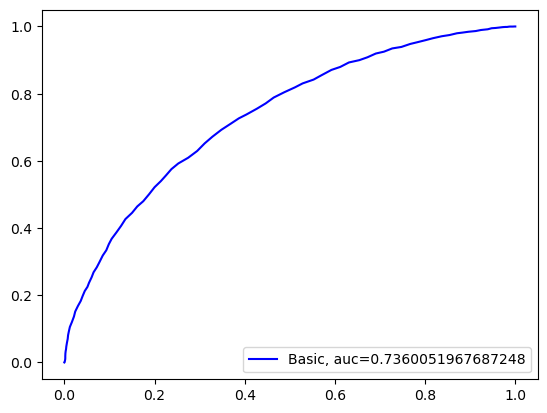

In [6]:
# Random Forest Basic parameters
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))


y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr_basic, tpr_basic, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_basic = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr_basic, tpr_basic, label="Basic, auc=" +
         str(auc_basic), color='blue')
plt.legend(loc=4)
plt.show()

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Score: 0.6676801108713027
Best Hyperparameters: {'n_estimators': 100, 'max_depth': 13, 'criterion': 'entropy'}


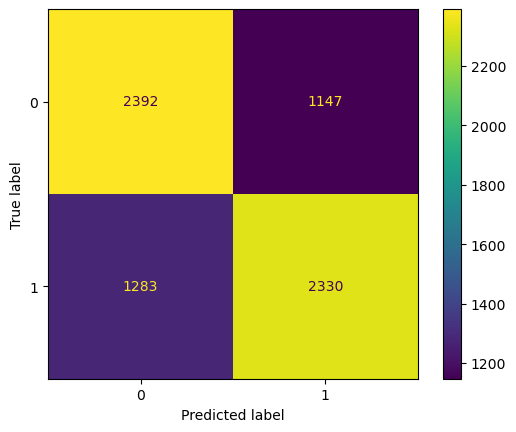

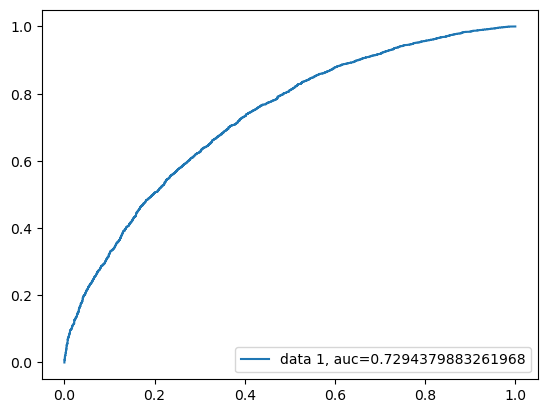

In [6]:
# Random Forest Hyperparameter Tuning

model = RandomForestClassifier()

param_grid = {
    'max_depth': list(range(5, 25, 2)),
    'n_estimators': list(range(80, 200, 10)),
    'criterion': ['gini', 'entropy'],
}

search = RandomizedSearchCV(model, param_grid, n_iter=10,
                            cv=10, scoring='accuracy', n_jobs=-1, random_state=1, verbose=2)

result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.show()

y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Optimal number of features : 15
                                  Rank
glicko_P1_diff                       1
ace_probability_P1_diff              1
total_serve_points_P1_diff           1
completeness_P1_diff                 1
points_on_return_P1_diff             1
first_won_serve_P1_diff              1
bp_factor_P1_diff                    1
surface_wins_P1_diff                 1
win_percentage_P1_diff               1
games_played_P1_diff                 1
age_P1_diff                          1
df_probability_P1_diff               1
rank_points_P1_diff                  1
first_serve_return_P1_diff           1
second_won_serve_P1_VS               1
second_won_serve_P1_diff             2
aceDf_P1_diff                        3
first_won_serve_P2_VS                4
serve_points_won_P1_diff             5
first_won_serve_P1_VS                6
second_won_serve_P2_VS               7
double_fault_probability_P2_VS       8
double_fault_probability_P1_VS       9
double_fault_probability_P1_diff

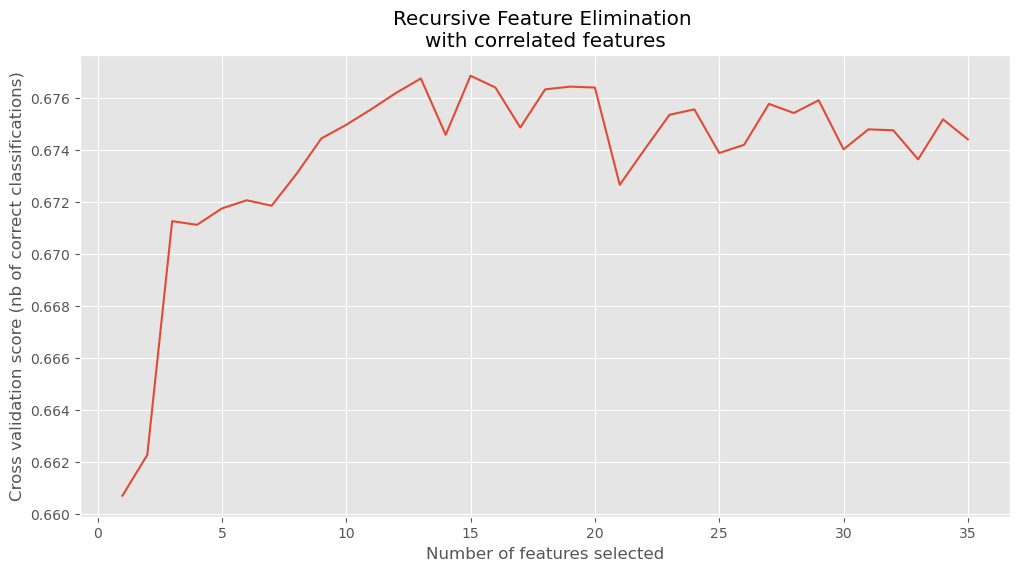

              precision    recall  f1-score   support

         0.0       0.66      0.69      0.67      3539
         1.0       0.68      0.66      0.67      3613

    accuracy                           0.67      7152
   macro avg       0.67      0.67      0.67      7152
weighted avg       0.67      0.67      0.67      7152



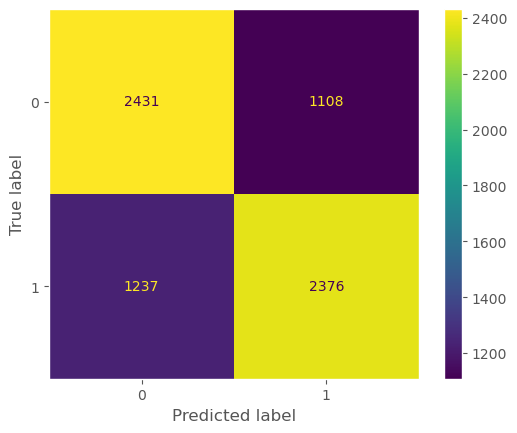

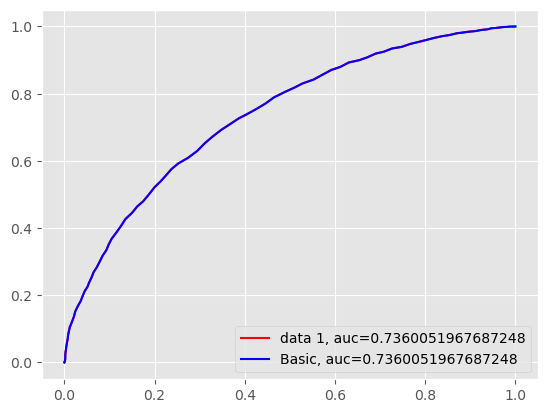

In [7]:
# Random Forest with RFECV

model = RandomForestClassifier(
    max_depth=13, n_estimators=100, criterion='entropy')

cv = StratifiedKFold(3)

rfecv = RFECV(model, cv=cv, scoring='accuracy', step=1)

rfecv.fit(X_train, y_train)

y_pred = rfecv.predict(X_test)

print('Optimal number of features : %d' % rfecv.n_features_)

ranks = pd.DataFrame(
    rfecv.ranking_, index=X.columns, columns=['Rank'])

print(ranks.sort_values(by='Rank', ascending=True))

# rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_, index=X.columns, columns=[
#                                       'Rank']).sort_values(by='Rank', ascending=True)
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv.cv_results_[
         "mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()


print(classification_report(y_test, y_pred))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.grid(False)
plt.show()

y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.grid(True)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc), color='red')
plt.plot(fpr_basic, tpr_basic, label="Basic, auc=" +
         str(auc_basic), color='blue')
plt.legend(loc=4)
plt.show()

# adaBoost


              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67      3539
         1.0       0.68      0.67      0.67      3613

    accuracy                           0.67      7152
   macro avg       0.67      0.67      0.67      7152
weighted avg       0.67      0.67      0.67      7152



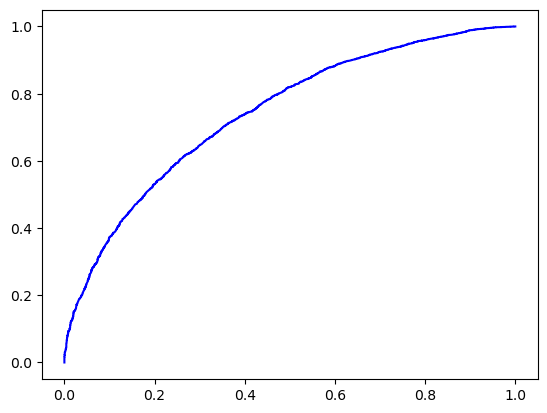

In [6]:
# AdaBoost Basic parameters

from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()

result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))


# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# cnf_matrix

# disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
# disp.plot()
# plt.show()

y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr_basic, tpr_basic, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_basic = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr_basic, tpr_basic, label="data 1, auc=" +
#          str(auc_basic), color='blue')
# plt.legend(loc=4)
# plt.show()

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Score: 0.6658974196024179
Best Hyperparameters: {'n_estimators': 190, 'learning_rate': 0.2}


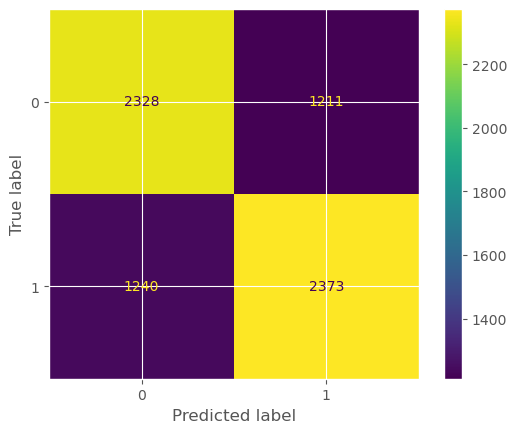

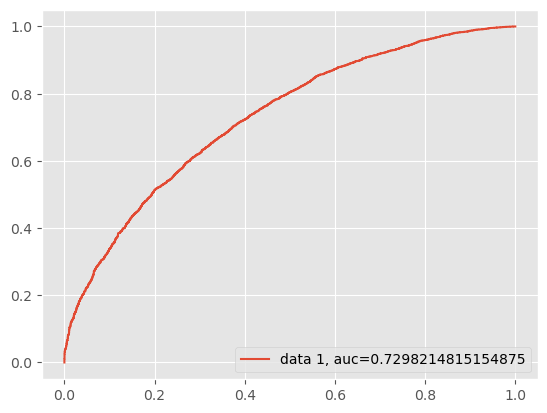

In [9]:
# AdaBoost Hyperparameter Tuning

model = AdaBoostClassifier()

param_grid = {
    'n_estimators': list(range(20, 200, 10)),
    'learning_rate': list(np.arange(0.1, 1.1, 0.1)),
}

search = RandomizedSearchCV(model, param_grid, n_iter=10,
                            cv=10, scoring='accuracy', n_jobs=-1, random_state=1, verbose=2)

result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.show()

y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Optimal number of features : 6
                                  Rank
ace_probability_P1_diff              1
second_won_serve_P1_diff             1
surface_wins_P1_diff                 1
win_percentage_P1_diff               1
age_P1_diff                          1
rank_points_P1_diff                  1
bp_factor_P1_diff                    2
serve_points_won_P1_diff             3
first_serve_return_P1_diff           4
games_played_P1_diff                 5
ace_probability_P2_VS                6
completeness_P1_diff                 7
glicko_P1_diff                       8
double_fault_probability_P2_VS       9
second_won_serve_P1_VS              10
elo_P1_diff                         11
aceDf_P2_VS                         12
df_probability_P1_diff              13
win_percentage_P2_VS                14
first_won_serve_P1_diff             15
second_won_serve_P2_VS              16
aceDf_P1_diff                       17
points_on_return_P1_diff            18
total_serve_points_P1_diff       

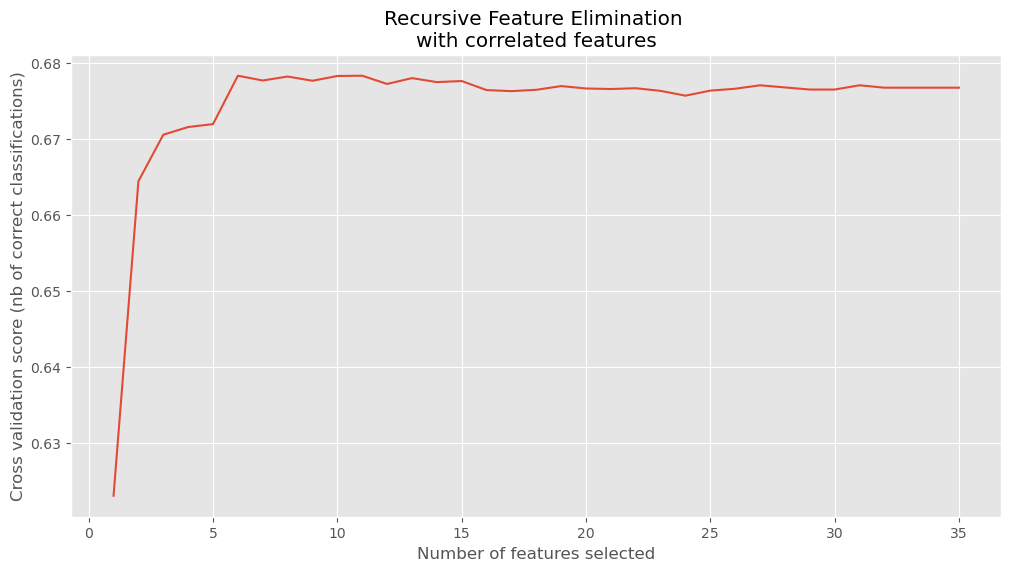

              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68      3539
         1.0       0.68      0.67      0.67      3613

    accuracy                           0.68      7152
   macro avg       0.68      0.68      0.68      7152
weighted avg       0.68      0.68      0.68      7152



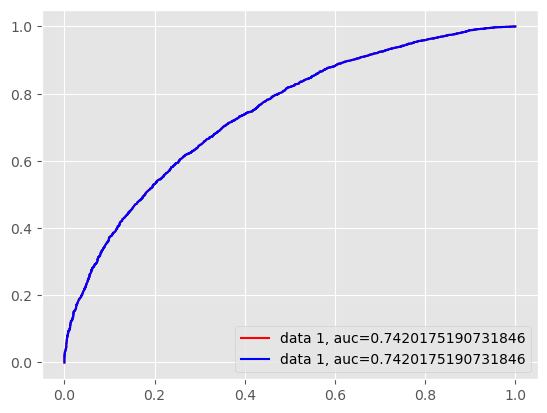

In [7]:
# AdaBoost with RFECV

model = AdaBoostClassifier(
    n_estimators=190, learning_rate=0.2, random_state=17)


cv = StratifiedKFold(3)

rfecv = RFECV(model, cv=cv, scoring='accuracy', step=1)

rfecv.fit(X_train, y_train)

y_pred = rfecv.predict(X_test)

print('Optimal number of features : %d' % rfecv.n_features_)

ranks = pd.DataFrame(
    rfecv.ranking_, index=X.columns, columns=['Rank'])

print(ranks.sort_values(by='Rank', ascending=True))

# rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_, index=X.columns, columns=[
#                                       'Rank']).sort_values(by='Rank', ascending=True)
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv.cv_results_[
         "mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()


print(classification_report(y_test, y_pred))


# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# cnf_matrix


# disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
# disp.plot()
# plt.grid(False)
# plt.show()

y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.grid(True)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc), color='red')
plt.plot(fpr_basic, tpr_basic, label="data 1, auc=" +
         str(auc_basic), color='blue')
plt.legend(loc=4)
plt.show()

In [5]:
# plots

from sklearn.ensemble import AdaBoostClassifier
import scikitplot as skplt

model = AdaBoostClassifier(
    n_estimators=190, learning_rate=0.2, random_state=17)


skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=10)

result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))

# Gradient boosting


              precision    recall  f1-score   support

         0.0       0.65      0.67      0.66      3539
         1.0       0.67      0.65      0.66      3613

    accuracy                           0.66      7152
   macro avg       0.66      0.66      0.66      7152
weighted avg       0.66      0.66      0.66      7152



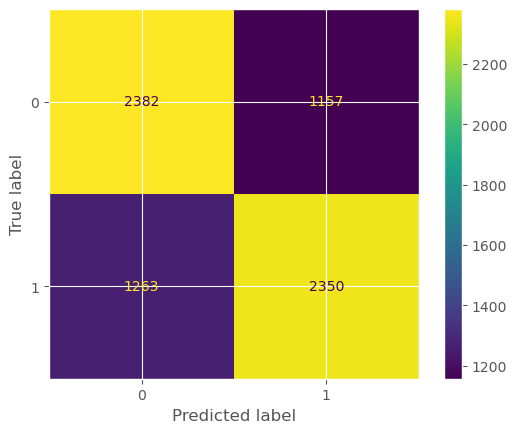

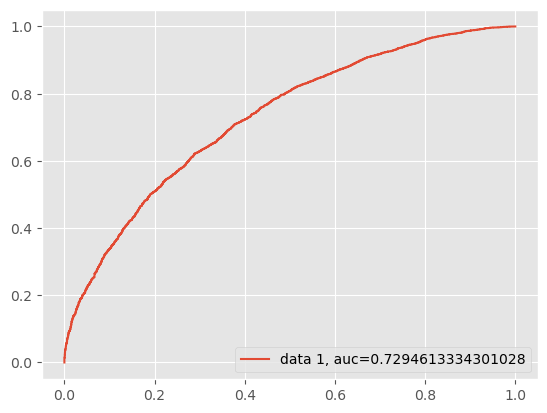

In [10]:
# Gradient Boosting Basic parameters

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()

result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))


y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr_basic, tpr_basic, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_basic = metrics.roc_auc_score(y_test, y_pred_proba)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Score: 0.6797816114878341
Best Hyperparameters: {'n_estimators': 100, 'loss': 'log_loss', 'learning_rate': 0.1, 'criterion': 'friedman_mse'}


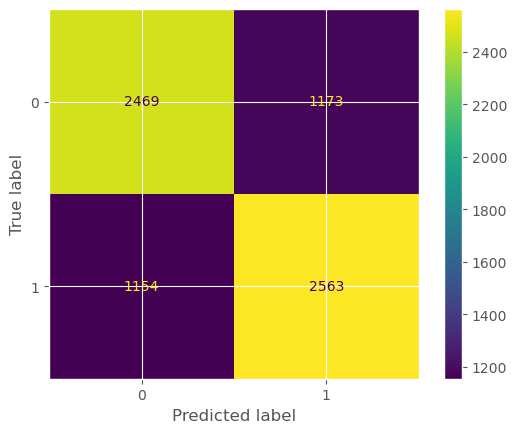

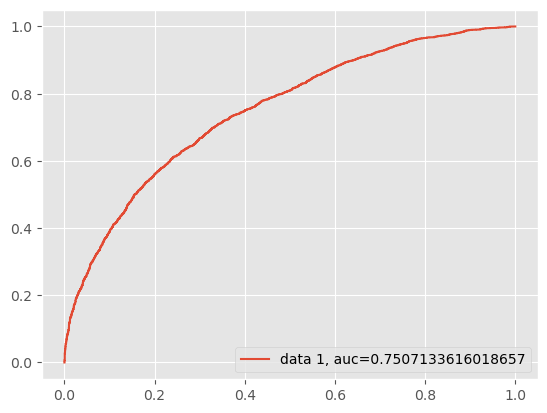

In [13]:
# Gradient Boosting Hyperparameter Tuning
model = GradientBoostingClassifier()

param_grid = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': list(np.arange(0.1, 1.1, 0.1)),
    'n_estimators': list(range(20, 200, 10)),
    'criterion': ['friedman_mse', 'squared_error',],
}

search = RandomizedSearchCV(model, param_grid, n_iter=10,
                            cv=10, scoring='accuracy', n_jobs=-1, random_state=1, verbose=2)

result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.show()

y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Optimal number of features : 9
                                  Rank
match_id                             1
ace_probability_P1_diff              1
rank_points_P1_diff                  1
completeness_P1_diff                 1
second_won_serve_P1_diff             1
surface_wins_P1_diff                 1
age_P1_diff                          1
games_played_P1_diff                 1
win_percentage_P1_diff               1
bp_factor_P1_diff                    2
first_won_serve_P1_diff              3
serve_points_won_P1_diff             4
glicko_P1_diff                       5
first_serve_return_P1_diff           6
df_probability_P1_diff               7
total_serve_points_P1_diff           8
aceDf_P1_diff                        9
elo_P1_diff                         10
points_on_return_P1_diff            11
double_fault_probability_P1_diff    12
draw_size                           13
ht_P1_diff                          14


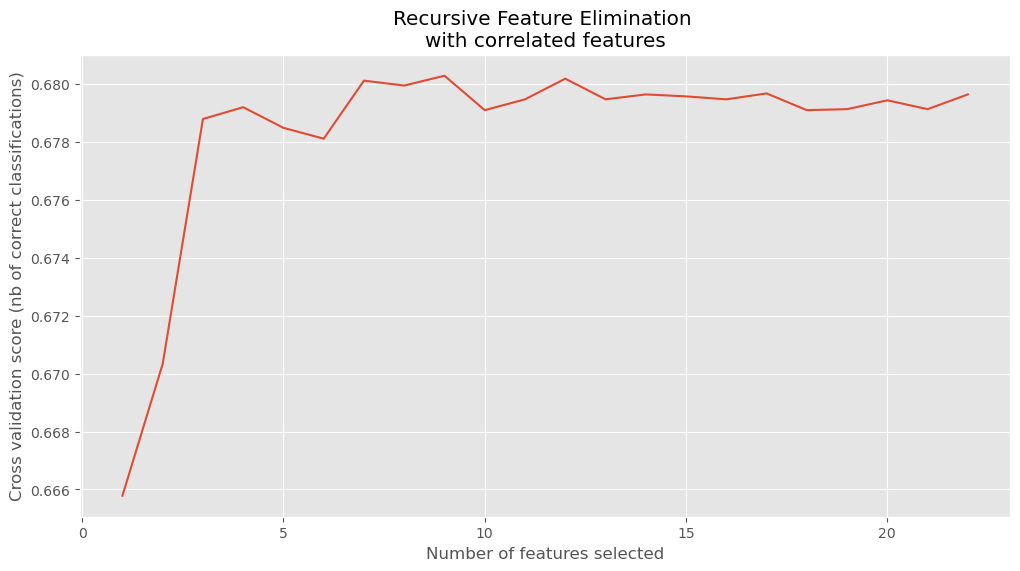

              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      3642
         1.0       0.69      0.68      0.68      3717

    accuracy                           0.68      7359
   macro avg       0.68      0.68      0.68      7359
weighted avg       0.68      0.68      0.68      7359



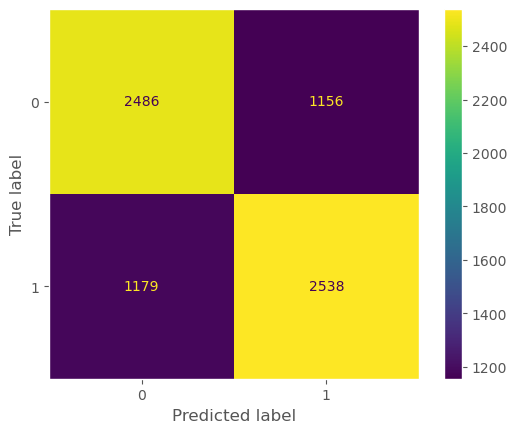

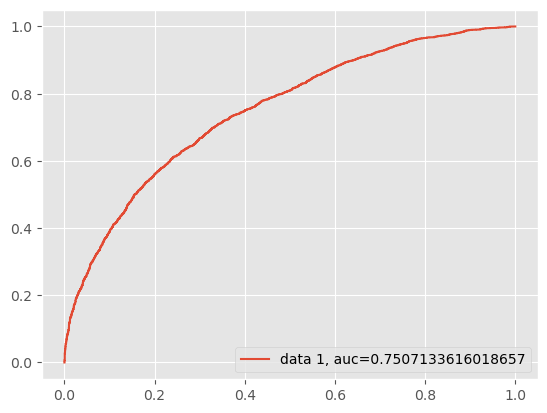

In [14]:
# Gradient Boosting with RFECV

model = GradientBoostingClassifier(
    loss='log_loss', learning_rate=0.1, n_estimators=100, criterion='friedman_mse')

cv = StratifiedKFold(3)

rfecv = RFECV(model, cv=cv, scoring='accuracy', step=1)

rfecv.fit(X_train, y_train)

y_pred = rfecv.predict(X_test)

print('Optimal number of features : %d' % rfecv.n_features_)

ranks = pd.DataFrame(
    rfecv.ranking_, index=X.columns, columns=['Rank'])

print(ranks.sort_values(by='Rank', ascending=True))

# rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_, index=X.columns, columns=[
#                                       'Rank']).sort_values(by='Rank', ascending=True)
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv.cv_results_[
         "mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

ranks_1 = ranks[ranks['Rank'] == 1]

print(classification_report(y_test, y_pred))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.grid(False)
plt.show()

y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.grid(True)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc), color='red')
plt.plot(fpr, tpr, label="data 1, auc="+str(auc_basic), color='blue')
plt.legend(loc=4)
plt.show()